### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera. 

In [2]:
import os 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
from scipy.spatial.transform import Rotation as R 
import matplotlib.pyplot as plt
from skimage import io, transform 
from PIL import Image    
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms, utils 
from typing import List, Dict, Tuple 
from tqdm import tqdm 

/home/jrached/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Dataset Class and Dataloader

In [ ]:
# Create dataset class 

class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5):
        """
        Go through each video folder and build a map from 
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where 
        j is the video number and k the frame index in that 
        video. For reference, the videos are stored in the 
        dataset as:  

        data: 
        - test1: 
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ... 
          - targets: 
            - frame0000.png
            - frame0001.png
            - ... 
        - test2: 
            - ... 
        - ... 
        """ 
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids 
        self.path_to_data = path_to_data 
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {} 
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose 
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly 
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")  

            # Get poses 
            self.poses[i] = pd.read_csv(pose_path).to_numpy() 
            self.twists[i] = pd.read_csv(twist_path).to_numpy() 

            # Get pose data frame 
            num_frames = self.poses[i].shape[0] 

            # Update index map 
            video_num = [i] * num_frames 
            frame_idx = list(range(0, num_frames))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_frames = len(self.idx_map)

    def __len__(self): 
        """
        Return length of dataset as computed in __init__() function. 
        """
        # Remove T last elements to prevent out of index error when retrieving sequence of length T
        return self.total_num_frames - self.seq_length
    
    def __getitem__(self, idx): 
        """ 
        Use map built in __init__() to retrieve the image, 
        pose, and twist directly from the dataset. 
        This avoids loading the entire dataset which 
        overwhelms RAM. 
        """
        assert idx < self.total_num_frames - self.seq_length 
        if torch.is_tensor(idx): 
            idx = idx.tolist() 

        # Define path to data 
        test_idx, frame_idx = self.idx_map[idx]
        padded_frame_idx = self.to_zero_pad_idx(frame_idx) 
        input_img_path = os.path.join(self.path_to_data,
                                f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
        output_img_path = os.path.join(self.path_to_data,
                                f'test{test_idx}/targets/frame{padded_frame_idx}.png')
        
        # Load and process data 
        input_frame = io.imread(input_img_path)        
        output_frame = io.imread(output_img_path)        
        input_frame = self.to_grayscale(input_frame) 
        output_frame = self.to_grayscale(output_frame) 
        pose = self.poses[test_idx][frame_idx]
        pose = self.pose_vector_from_matrix(pose)
        twist = self.twists[test_idx][frame_idx]

        if self.augmented: 
            h, w = input_frame.shape 
            expanded_frame = torch.from_numpy(input_frame).float().view(h, w, 1) 
            expanded_pose = torch.from_numpy(pose).float().view(1, 1, -1).repeat(h, w, 1)
            expanded_twist = torch.from_numpy(twist).float().view(1, 1, -1).repeat(h, w, 1)  
            augmented_frame = torch.cat((expanded_frame, expanded_pose, expanded_twist), dim=-1)
            
            return {'input': augmented_frame, 'target': torch.from_numpy(output_frame).float()}

        return {'input': (torch.from_numpy(input_frame).float(), torch.from_numpy(pose).float(), torch.from_numpy(twist).float()), 'target': torch.from_numpy(output_frame).float()}

    def to_zero_pad_idx(self, idx):
        """ 
        Convert frame index from regular index to lexicographical index. 
        e.g. 1 -> 00001, 12 -> 00012 
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose): 
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector. 
        """
        pose = pose.reshape(4, 4) 
        position = pose[:3, 3].reshape(3, 1) 
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1) 
        norm_quat = quat / np.linalg.norm(quat) 

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """ 
        Convert PNG image to grayscale mask 
        """ 
        #TODO: Try float16 type 
        return (image[..., 0] > 127).astype(np.float32)
        

        

In [ ]:
# Make dataloader and load data 
path_to_data = '/home/jrached/cv_project_code/project/data/filter_net/processed_flow'
dataset = VideoDataset(path_to_data, augmented=False)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=1) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


100%|██████████| 7/7 [00:00<00:00, 123.33it/s]


### Image and State Encoders

In [ ]:
# Use transforms to resize images 
# This is an example, but it must actually be performed before feeding image data to encoder
features = next(iter(loader)) 
transform = transforms.Resize((256, 256))
resized_img = transform(features[0])
resized_img.shape

In [ ]:
# Write classes for compression networks 

class ImgEncoder(nn.Module): 
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        """
        super().__init__()
        linear_in_dim = out_channel * 64 ** 2 
        linear_out_dim = 1024
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, 16, stride=2, padding=7), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, 4, stride=2, padding=1), # h_in, w_in = (128, 128); h_out, w_out = (64, 64) 
                            nn.ReLU(), 
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        ) 

    def forward(self, x): 
        """
        Define neural network forward pass 
        """
        return self.conv_stack(x)
    

class StateEncoder(nn.Module): 
    def __init__(self, in_dim=13, out_dim=128): 
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector. 
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x): 
        """ 
        Define nueral network forward pass 
        """
        return self.linear_layer(x) 

In [ ]:
# Test conv encoder 
mock_img_data = torch.zeros((64, 1, 256, 256))
img_encoder = ImgEncoder() 
img_embedding = img_encoder(mock_img_data) 

# Test state encoder 
mock_state_data = torch.zeros((64, 13))
state_encoder = StateEncoder()
state_embedding = state_encoder(mock_state_data)


In [ ]:
img_embedding.shape
state_embedding.shape

### LSTM 

LSTM class with image and state embeddings 


In [ ]:
# Define LSTM class 
class FilterNet(nn.Module):
    def __init__(self, in_dim=1152, hidden_dim=512):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm 
        lstm input dimension is then 1024 + 128 = 1152 
        """
        super().__init__()
        self.in_dim = in_dim 
        self.hidden_dim = hidden_dim 
        self.image_encoder = ImgEncoder()
        self.state_encoder = StateEncoder() 
        self.lstm = nn.LSTM(in_dim, hidden_dim ) 


### Traning Loop

### Testing: 
#### Testing Dataloader

In [72]:
counter = 0 
for datapoint in loader:
    found_one = False
    features = datapoint['input']
    labels = datapoint['target']

    for i in range(32):
        image = features[0][i] 
        if counter > 1502:
            found_one = True
            break
        counter += 1
    
    if found_one: 
        break


In [73]:
features[0].shape
counter

1503

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

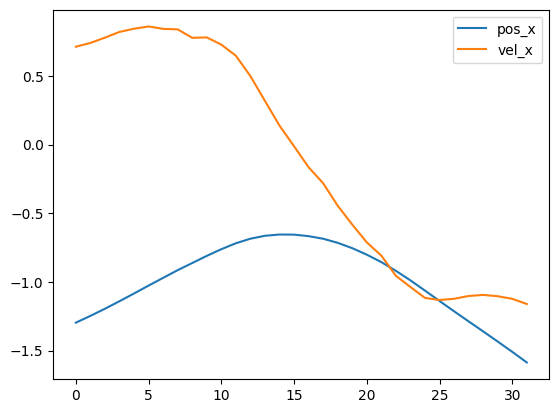

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

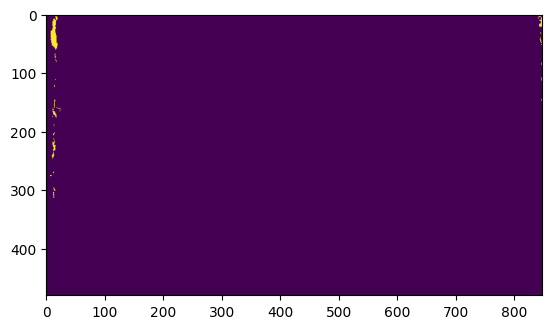

In [67]:
image = features[0][28] 
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])